# Region-based Convolutional Neural Network - Two Stage Object Detection

In [1]:
# Importing necessary Libraries

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
import random
from IPython.display import clear_output

warnings.filterwarnings('ignore')

In [2]:
# Defining the paths for images and annotations

images_path = "../Data/" + os.path.basename(os.getcwd()) + "/Images/Images"
annotations_path = "../Data/" + os.path.basename(os.getcwd()) + "/Airplanes_Annotations"


# images_path contains the images data
# annotation_path contains the coordinate data for the aeroplanes

#### Preview of "Hand made bounding boxes" and "Proposed Bouding boxes" by CV2-SelectiveSearchSegmentation

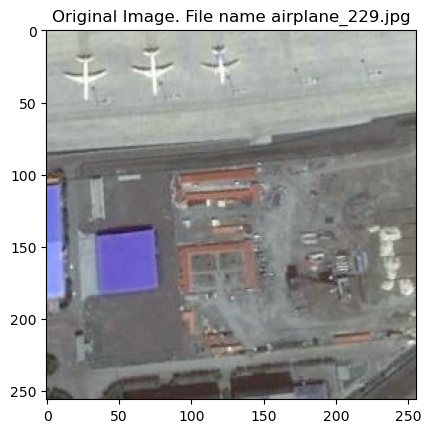

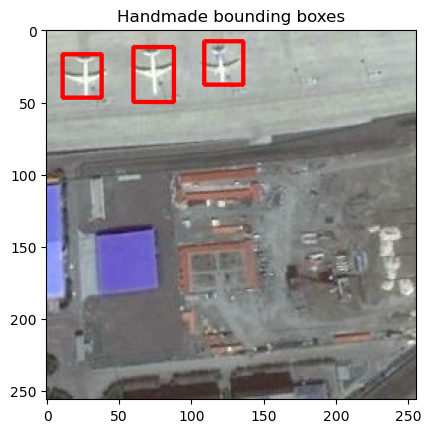

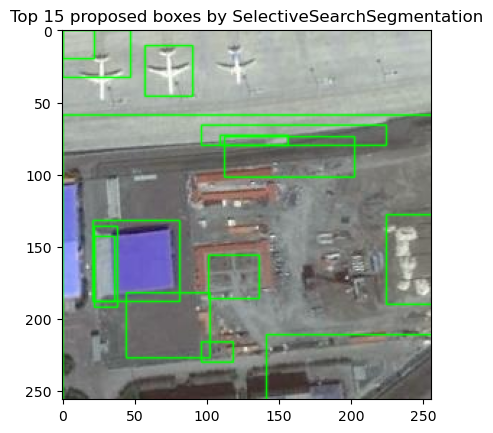

In [3]:
# Selecting random annotation from the annotations directory

random_annot = random.choice(os.listdir(annotations_path))
random_img = random_annot.split(".")[0] + ".jpg"


original_image = cv2.imread(os.path.join(images_path, random_img))

plt.imshow(original_image)
plt.title("Original Image. File name " + random_img)
plt.show()


annotated_image = original_image.copy()
annotation_df = pd.read_csv(os.path.join(annotations_path, random_annot))

# Drawing handmade boundary boxes
for row in annotation_df.iterrows():
    x1, y1, x2, y2 = map(int, row[1].values[0].split())
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(annotated_image)
plt.title("Handmade bounding boxes")
plt.show()

# Drawing proposed bounding boxes
proposedbox_image = original_image.copy()
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(original_image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

for i, rect in (enumerate(rects[:15])):
    x,y,w,h = rect
    cv2.rectangle(proposedbox_image, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(proposedbox_image)
plt.title("Top 15 proposed boxes by SelectiveSearchSegmentation")
plt.show()

### Extracting Region Proposals and building Train Data

In [4]:
# Creating two empty lists. One for storing images and one for storing labels
train_images = []
train_labels = []

In [5]:
# Defining function for IntersectionOverUnion

def get_iou(bb1, bb2):
    """This function return the Intersection over Union for the given two boundaries.
    This measure is between 0 and 1. It tells us how similar two given boundary boxes are."""
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    
    x_left = max(bb1['x1'], bb2['x1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    y_top = max([bb1['y1'], bb2['y1']])
    
    if (x_right < x_left) or (y_bottom < y_top):
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    iou = intersection_area/float(bb1_area + bb2_area - intersection_area)
    
    assert iou <= 1.0
    assert iou >= 0.0
    
    return iou

In [6]:
# Instantiating Selective Search Segmentation Object
sss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
total_files = len(os.listdir(annotations_path))

for file_num, annot_file in enumerate(os.listdir(annotations_path)):
    try:
    # Progress bar
        clear_output(wait=True)
        print("|" + "="*int((file_num * 100 / total_files) // 10) + 
              ">" + " " * (9 - int((file_num * 100 / total_files) // 10)) + "| " +
              str(int((file_num * 100 / (total_files-1)))) + "%") 
            
            
        if annot_file.startswith("airplane"):
            filename = annot_file.split(".")[0] + ".jpg"
            # Loading image file and annotations for boundary box/es
            original_image = cv2.imread(os.path.join(images_path, filename))
            annotation_df = pd.read_csv(os.path.join(annotations_path, annot_file))
            
            # Extracting boundary box details from annotations dataframe to a list
            boundaryboxes = []
            for row in annotation_df.iterrows():
                x1, y1, x2, y2 = map(int, row[1].values[0].split())
                boundaryboxes.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})
                
            # Processing the top 2000 proposed boundary boxes for each image
            sss.setBaseImage(original_image)
            sss.switchToSelectiveSearchFast()
            proposed_boundaryboxes = sss.process()[:2000]
            
            # Creating a duplicate image
            duplicate_image = original_image.copy()
            
            # Initializing some Tracking variables
            counter = 0
            falsecounter = 0
            true_flag = False
            false_flag = False
            
            
            # Iterating over each proposed_boundary_box and each boundarybox and collecting data for training and testing
            for bbox_count, proposed_bbox in enumerate(proposed_boundaryboxes):
                x, y, w, h = proposed_bbox
                for boundarybox in boundaryboxes:
                    # Calculating Intersection over Union
                    iou = get_iou(boundarybox,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    
                    if counter < 30:
                        if iou > 0.7:
                            cropped_image = duplicate_image[y: y+h, x: x+w]
                            resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized_image)
                            train_labels.append(1)
                            counter += 1
                            
                    else:
                        true_flag = True
                    
                    if falsecounter < 30:
                        if iou < 0.3:
                            cropped_image = duplicate_image[y: y+h, x: x+w]
                            resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized_image)
                            train_labels.append(0)
                            falsecounter += 1
                    
                    else:
                        false_flag = True
                        
                    if true_flag and false_flag:
                        break
                        
    except Exception as e:
        print(e)
        print("Error in " + annot_file)
        continue

|=========>| 100%


#### Transfer Learning of VGG16

In [8]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

X_new = np.array(train_images)
y_new = np.array(train_labels)


# The include_top=True means that the fully connected layers at the end 
# (typically used for classification into 1000 ImageNet classes) are also loaded
vggmodel = VGG16(weights='imagenet', include_top=True)

# This loop goes through the first 15 layers of the VGG16 model and freezes them,
# meaning that during training, their weights won't be updated.
# This is often done when you want to keep the feature extraction capability of the pre-trained model
# but adjust the latter part of the model to your specific task.

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
    
# This gets the output of the second last layer of the VGG16 model.   
X= vggmodel.layers[-2].output


# A new dense layer with 2 neurons (implying a binary classification task) is added. 
# The softmax activation function ensures the output values can be interpreted as probabilities.
predictions = Dense(2, activation="softmax")(X)

# A new model (model_final) is created which uses the same input as the VGG16 model (vggmodel.input) but
# ends with the new dense layer (predictions).
model_final = Model(vggmodel.input, predictions)

opt = Adam(lr=0.0001)

# This prepares the model for training. It specifies the loss function, optimizer, and metrics to keep track of during training.
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

clear_output()
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


# The primary reason for this custom MyLabelBinarizer is to handle binary classification scenarios in a specific way.
# Instead of returning a single column for binary encoded labels, it returns two columns (one for each class).
# The inverse_transform is then adjusted to handle this custom behavior.
# This can be useful in certain scenarios where you need a consistent output format regardless of the number of classes.
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
        
        
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

#### Data Augmentation

In [10]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90,  width_shift_range=0.2, height_shift_range=0.2)
traindata = trdata.flow(x=X_train, y=y_train)

tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90,  width_shift_range=0.2, height_shift_range=0.2)
testdata = tsdata.flow(x=X_test, y=y_test)

#### Training the Model

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("../Data/Object-Detection-RCNN-Airplane-Data/Model files/ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 1.4444 - accuracy: 0.7188
Epoch 1: val_loss improved from inf to 0.39265, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 24s 897ms/step - loss: 1.4444 - accuracy: 0.7188 - val_loss: 0.3926 - val_accuracy: 0.8438
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8062
Epoch 2: val_loss improved from 0.39265 to 0.29041, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 8s 783ms/step - loss: 0.3816 - accuracy: 0.8062 - val_loss: 0.2904 - val_accuracy: 0.8750
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8656
Epoch 3: val_loss did not improve from 0.29041
10/10 [==============================] - 5s 526ms/step - loss: 0.3887 - accuracy: 0.8656 - val_loss: 0.3274 - val_accuracy: 0.8594
Epoch 4/1000
10/10 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8813
Epo

10/10 [==============================] - 10s 1s/step - loss: 0.2961 - accuracy: 0.8938 - val_loss: 0.1375 - val_accuracy: 0.9844
Epoch 30/1000
10/10 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9344
Epoch 30: val_loss did not improve from 0.13748
10/10 [==============================] - 6s 519ms/step - loss: 0.1812 - accuracy: 0.9344 - val_loss: 0.4987 - val_accuracy: 0.9219
Epoch 31/1000
10/10 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9312
Epoch 31: val_loss did not improve from 0.13748
10/10 [==============================] - 5s 537ms/step - loss: 0.2819 - accuracy: 0.9312 - val_loss: 0.2172 - val_accuracy: 0.9062
Epoch 32/1000
10/10 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9219
Epoch 32: val_loss did not improve from 0.13748
10/10 [==============================] - 5s 537ms/step - loss: 0.2164 - accuracy: 0.9219 - val_loss: 0.1602 - val_accuracy: 0.9531
Epoch 33/1000
10/10 [======================

Epoch 59/1000
10/10 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9344
Epoch 59: val_loss did not improve from 0.05434
10/10 [==============================] - 6s 571ms/step - loss: 0.1449 - accuracy: 0.9344 - val_loss: 0.1788 - val_accuracy: 0.9531
Epoch 60/1000
10/10 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9469
Epoch 60: val_loss did not improve from 0.05434
10/10 [==============================] - 6s 556ms/step - loss: 0.1595 - accuracy: 0.9469 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 61/1000
10/10 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9500
Epoch 61: val_loss did not improve from 0.05434
10/10 [==============================] - 5s 548ms/step - loss: 0.1523 - accuracy: 0.9500 - val_loss: 0.1106 - val_accuracy: 0.9688
Epoch 62/1000
10/10 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9438
Epoch 62: val_loss did not improve from 0.05434
10/10 [====================

Epoch 89/1000
10/10 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9250
Epoch 89: val_loss did not improve from 0.05434
10/10 [==============================] - 6s 596ms/step - loss: 0.1707 - accuracy: 0.9250 - val_loss: 0.2377 - val_accuracy: 0.9219
Epoch 90/1000
10/10 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9531
Epoch 90: val_loss improved from 0.05434 to 0.04291, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 14s 1s/step - loss: 0.1511 - accuracy: 0.9531 - val_loss: 0.0429 - val_accuracy: 0.9844
Epoch 91/1000
10/10 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9250
Epoch 91: val_loss did not improve from 0.04291
10/10 [==============================] - 5s 495ms/step - loss: 0.1875 - accuracy: 0.9250 - val_loss: 0.2588 - val_accuracy: 0.8750
Epoch 92/1000
10/10 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9406
Epoch 92: val_loss did not improve f

10/10 [==============================] - 6s 582ms/step - loss: 0.1518 - accuracy: 0.9281 - val_loss: 0.0872 - val_accuracy: 0.9531
Epoch 119/1000
10/10 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9688
Epoch 119: val_loss did not improve from 0.04291
10/10 [==============================] - 6s 600ms/step - loss: 0.1282 - accuracy: 0.9688 - val_loss: 0.3514 - val_accuracy: 0.9062
Epoch 120/1000
10/10 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9406
Epoch 120: val_loss did not improve from 0.04291
10/10 [==============================] - 6s 590ms/step - loss: 0.1514 - accuracy: 0.9406 - val_loss: 0.1159 - val_accuracy: 0.9531
Epoch 121/1000
10/10 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9500
Epoch 121: val_loss did not improve from 0.04291
10/10 [==============================] - 6s 580ms/step - loss: 0.1324 - accuracy: 0.9500 - val_loss: 0.2465 - val_accuracy: 0.9062
Epoch 122/1000
10/10 [=============

KeyboardInterrupt: 

#### Testing a sample image

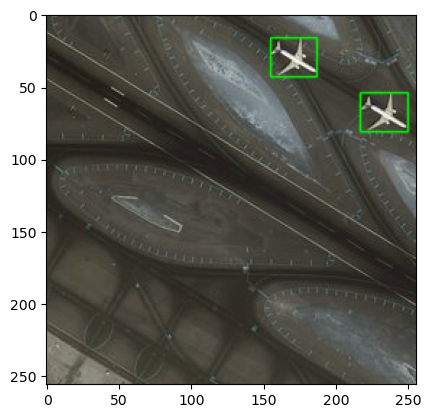

In [13]:
z=0
for e,i in enumerate(os.listdir(images_path)):
    if i.startswith("428481"):
        z += 1
        img = cv2.imread(os.path.join(images_path,i))
        sss.setBaseImage(img)
        sss.switchToSelectiveSearchFast()
        ssresults = sss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        clear_output()
        plt.figure()
        plt.imshow(imout)
        break